# Проект: Определение стоимости автомобилей

[yandex_practicum](https://practicum.yandex.ru/learn/data-scientist/courses/690358eb-b995-45f6-bde0-6260f7ad4df8/sprints/176084/topics/d3e1f0bf-daa2-4d7b-99a2-c958bfe85f28/lessons/c80a240f-f88a-48a6-b0d0-5839385a1c86/)

Описание проекта:

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать <font color='red'>количество заказов </font>такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.



## Описание данных

Признаки



Целевой признак
- 'num_orders' (от англ. number of orders, «число заказов»).



## 1.  Подготовка данных



### 1.1 Загружаем библиотеки и читаем данные


In [129]:

# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import random
import math
import calendar

# библиотека для оценки корреляции
from phik import phik_matrix


# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

#from sklearn.feature_selection import SelectKBest, f_classif
#from imblearn.over_sampling import SMOTE


# библиотеки для пайплайнов
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# класс для работы с пропусками
#from sklearn.impute import SimpleImputer

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score, make_scorer, root_mean_squared_error

# библиотеки для градиентного бустинга
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# библиотека для "глупой" модели
from sklearn.dummy import DummyClassifier, DummyRegressor



# библиотека решающих деревьев
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


# бибилиотека для графика ROC-кривой и расчёта ROC-AUC
#from sklearn.metrics import roc_auc_score, RocCurveDisplay



# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
#import plotly.express as px 
#import plotly.graph_objects as go



In [2]:

try:
    data = pd.read_csv('/datasets/taxi.csv')
except FileNotFoundError:
    data = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/13_time_series/data/taxi.csv')

data.head()


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пустых значений нет, а вот данные в столбце datetime нужно перевести в одноименный тип данных

In [4]:
data['ts'] = data.datetime.astype('datetime64')

In [5]:
data.drop('datetime', axis=1, inplace=True)

In [6]:
data.head()

,num_orders,ts
0,9,2018-03-01 00:00:00
1,14,2018-03-01 00:10:00
2,28,2018-03-01 00:20:00
3,20,2018-03-01 00:30:00
4,32,2018-03-01 00:40:00


In [7]:
temp_df = data.copy()

temp_df['year'] = temp_df.ts.dt.year

temp_df['month'] = temp_df.ts.dt.month

temp_df['day'] = temp_df.ts.dt.day

temp_df['hour'] = temp_df.ts.dt.hour

temp_df['minute'] = temp_df.ts.dt.minute

temp_df.head()

,num_orders,ts,year,month,day,hour,minute
0,9,2018-03-01 00:00:00,2018,3,1,0,0
1,14,2018-03-01 00:10:00,2018,3,1,0,10
2,28,2018-03-01 00:20:00,2018,3,1,0,20
3,20,2018-03-01 00:30:00,2018,3,1,0,30
4,32,2018-03-01 00:40:00,2018,3,1,0,40


In [8]:
for col in temp_df.drop(['num_orders', 'ts'], axis=1).columns:
    print(f'{col}, число уникальных значений {temp_df[col].nunique()}')
    print(temp_df[col].unique())
    print()

year, число уникальных значений 1
[2018]

month, число уникальных значений 6
[3 4 5 6 7 8]

day, число уникальных значений 31
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

hour, число уникальных значений 24
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

minute, число уникальных значений 6
[ 0 10 20 30 40 50]



Судя по всему, в столбце ts стоят временные метки числа заказов за 2018 год с марта по август <font color='red'> каждые 10 минут  </font>

Установим столбец ts в качестве индексов


In [9]:

data.set_index('ts', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим верность хронологии индексов (временного ряда)

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic (англ. «монотонный»). Если порядок соблюдён, атрибут вернёт True, если нет — False.

Отсортируем индекс таблицы. 

In [10]:
data = data.sort_index()

print(data.index.is_monotonic_increasing)


True


In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


### 1.2 Ресэмплирование

Выполним ресэмплирование по часу, построим график

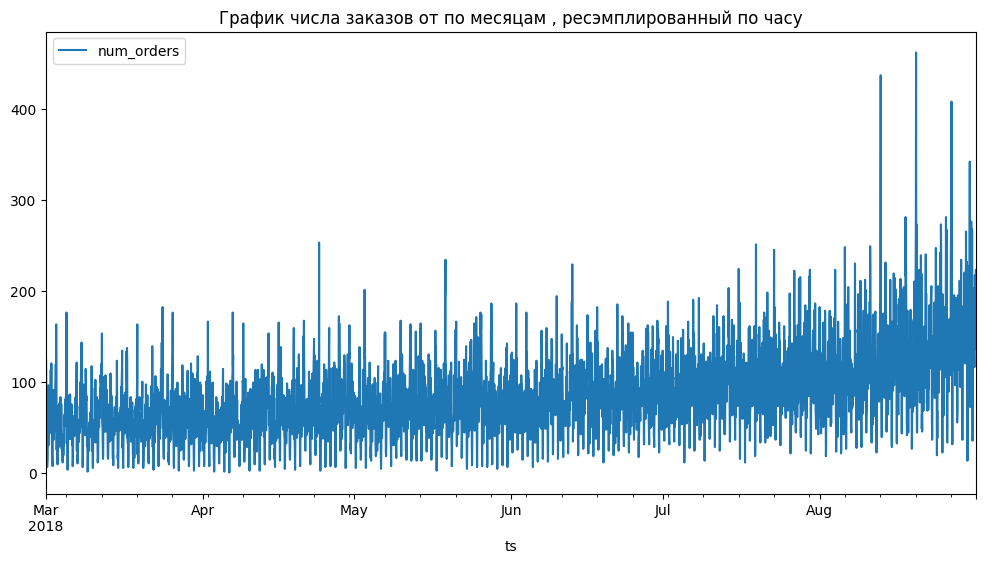

In [19]:

data.resample('1H').sum().plot(figsize=(12,6))
plt.title('График числа заказов от по месяцам , ресэмплированный по часу')

plt.show()


Добавим скользящее среднее с окном, равным 10 , и вычислим среднее значение для сглаживания графика

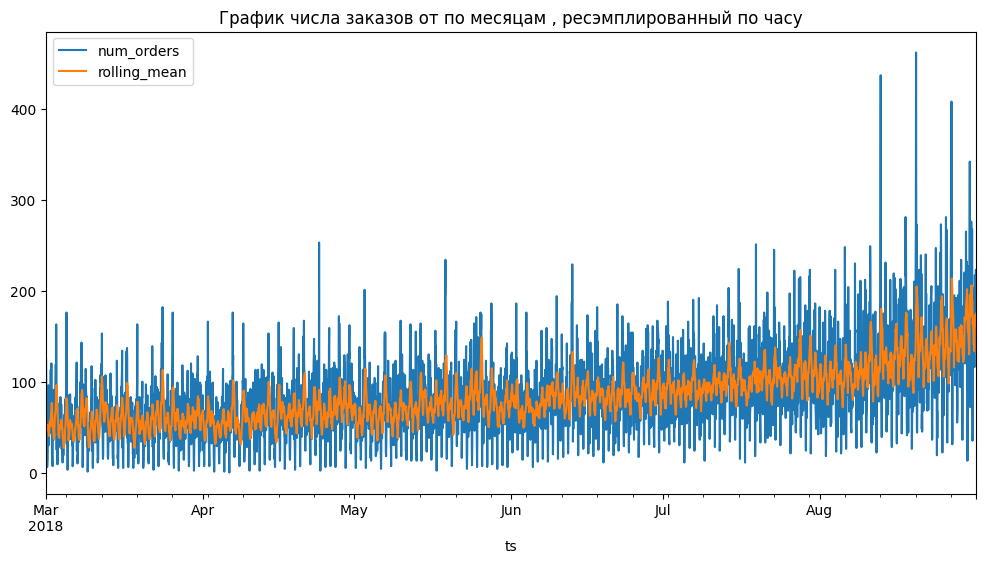

In [20]:
temp_df = data.resample('1H').sum()

temp_df['rolling_mean'] = temp_df.rolling(10).mean() 


temp_df.plot(figsize=(12,6))
plt.title('График числа заказов от по месяцам , ресэмплированный по часу')

plt.show()


Оставим подготовленные данные с ресеплированием по часу

In [67]:
data_resampled = data.resample('1H').sum()


## 2. Анализ  

### 2.1 Тренды, сезонность и остатки

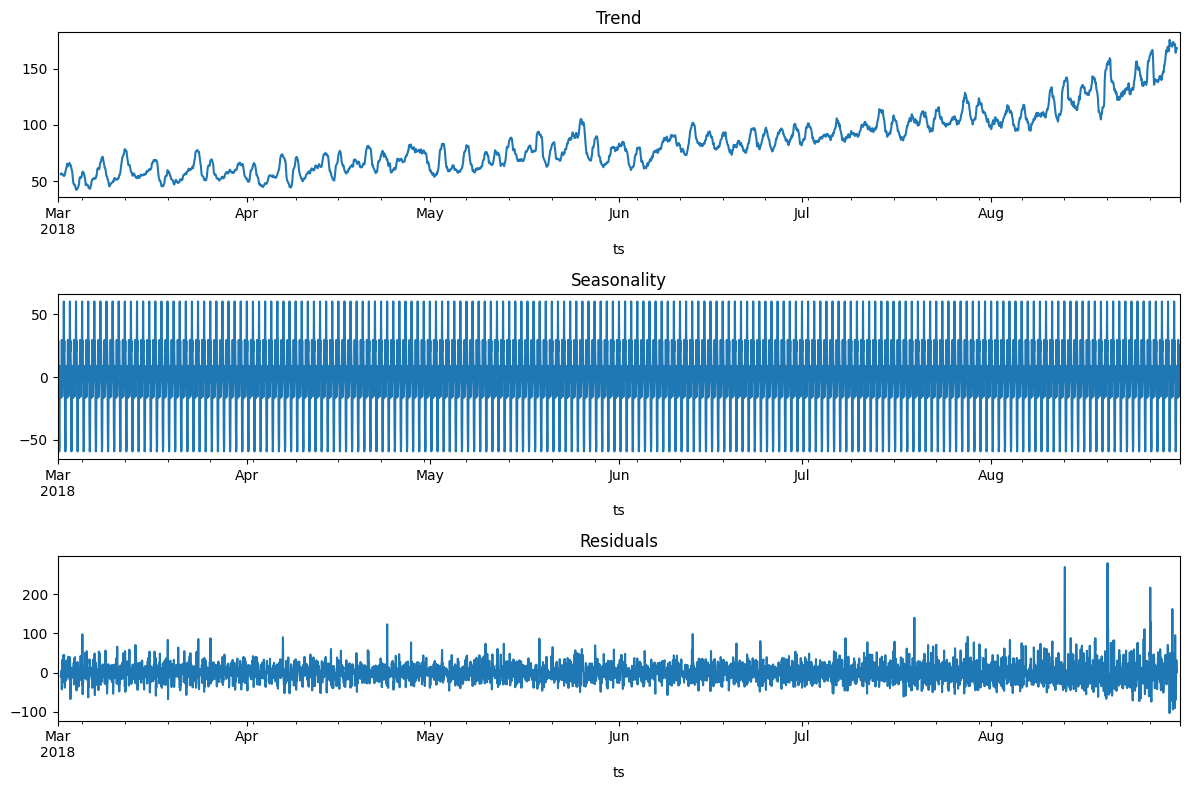

In [23]:
temp_df = data.resample('1H').sum()

decomposed = seasonal_decompose(temp_df) 

plt.figure(figsize=(12, 8))
plt.subplot(311)

# расположить графики друг под другом 
# корректные оси графиков

# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Сделаем срезы по месяцу и посмотрим как распределяются тренд и сезонность

In [48]:
# напишем функцию построения для удобства

def plot_trend_seasonality(temp_df, month_name):

    decomposed = seasonal_decompose(temp_df) 

    plt.figure(figsize=(12, 8))
    plt.subplot(211)

    # расположить графики друг под другом 
    # корректные оси графиков

    # Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    plt.title(f'Тренд числа заказов для месяца {month_name}')

    plt.subplot(212)
    decomposed.seasonal.plot(ax=plt.gca()) 
    plt.title(f'Сезонность числа заказов для месяца {month_name}')



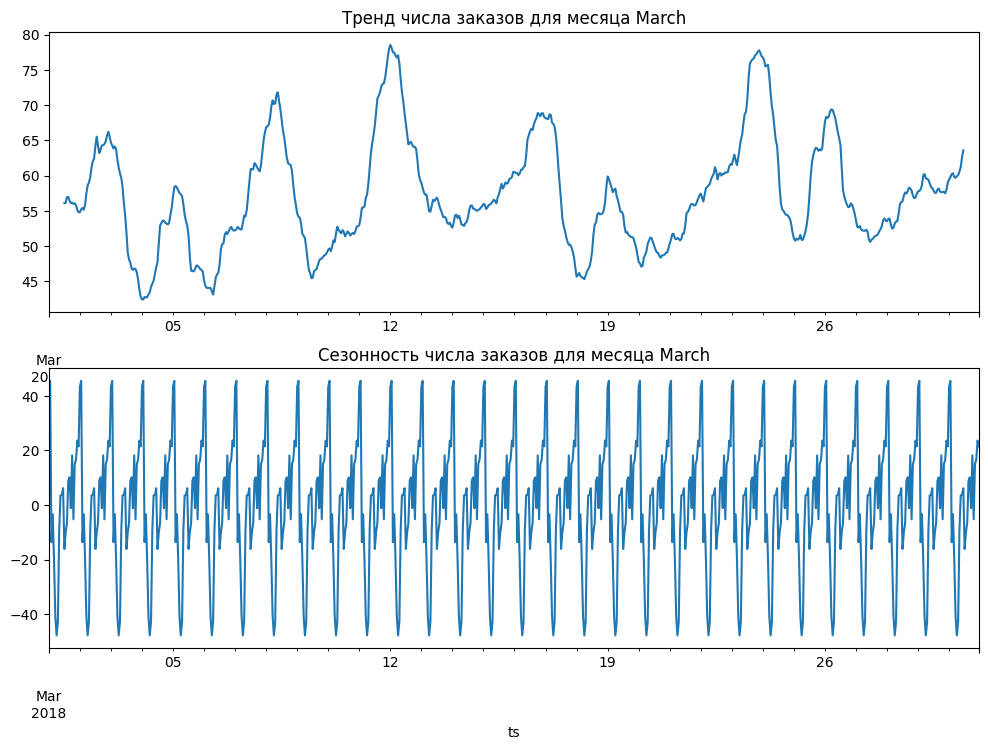

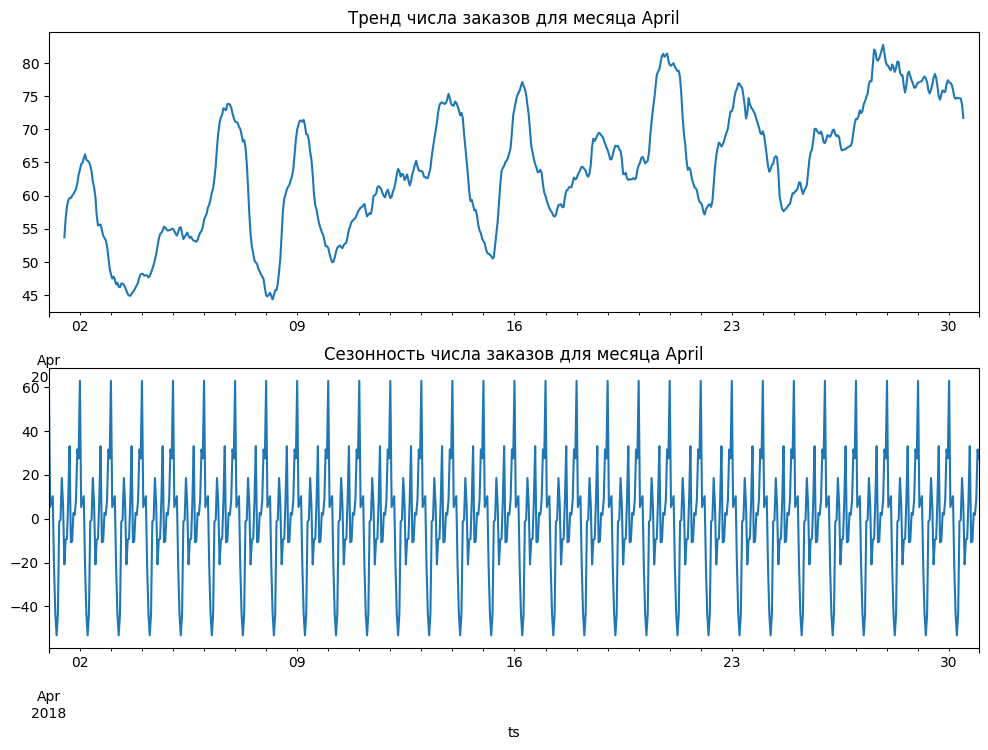

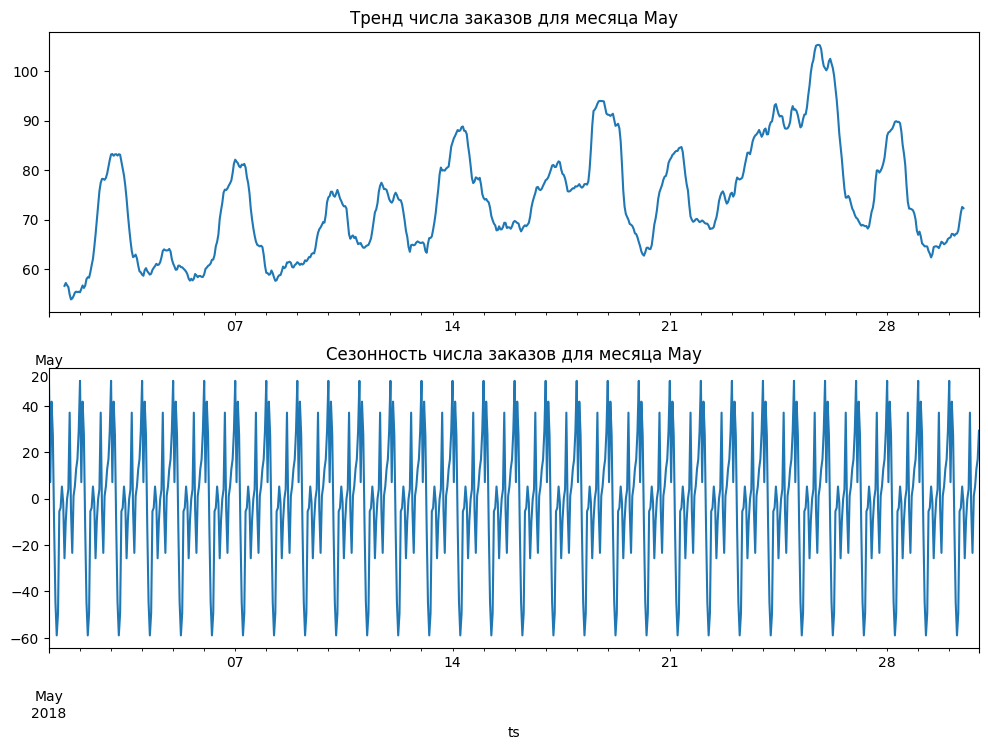

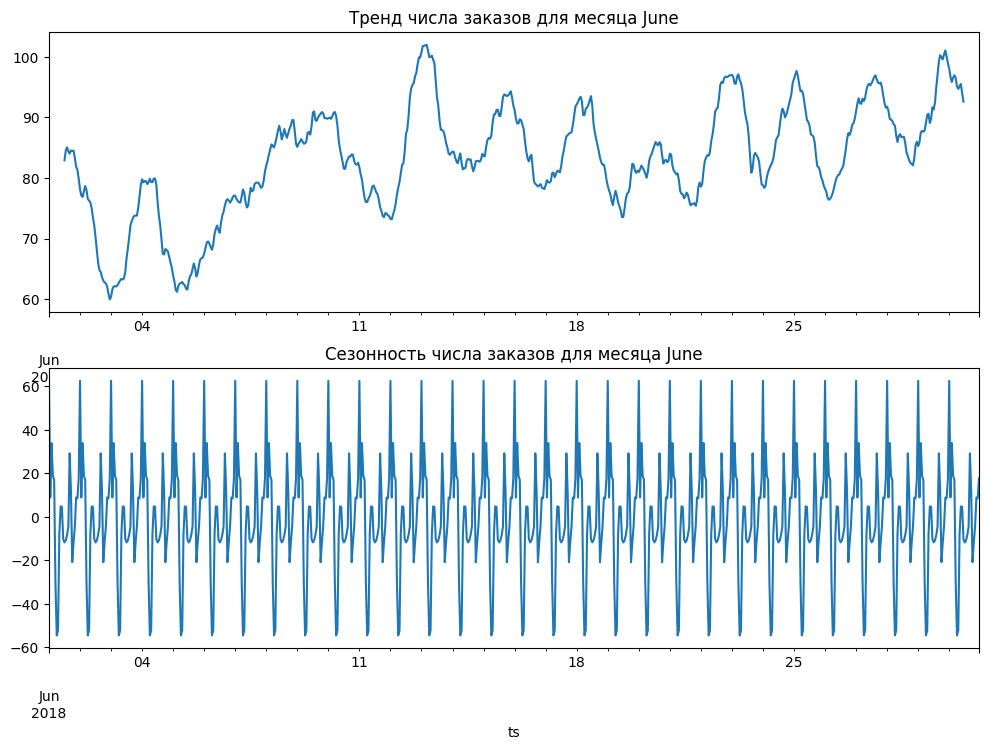

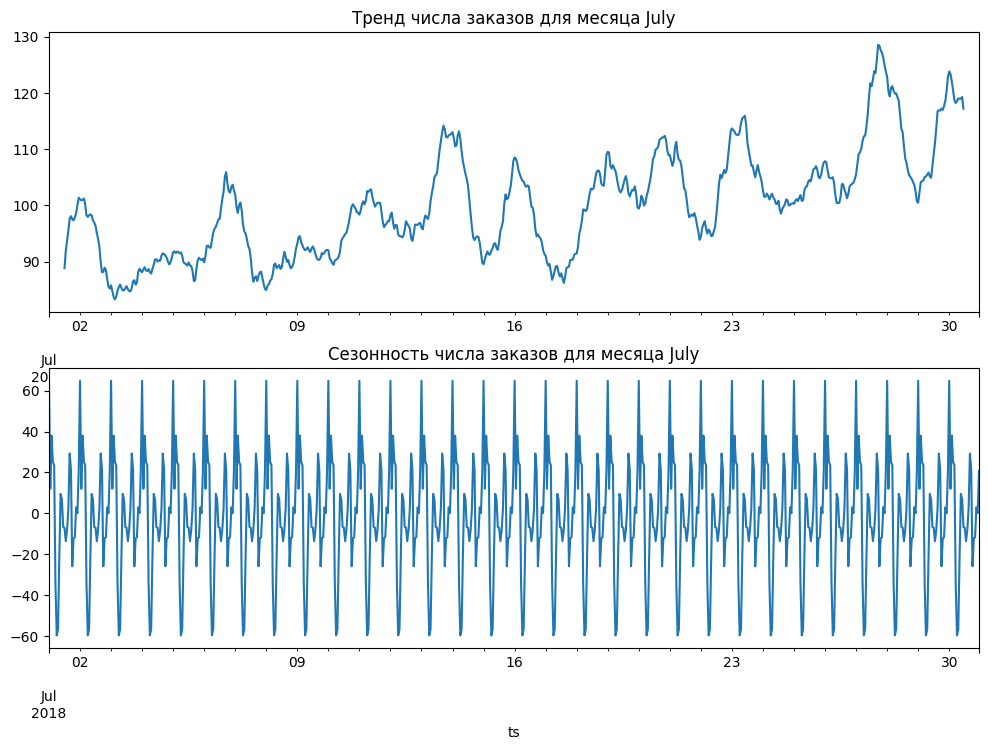

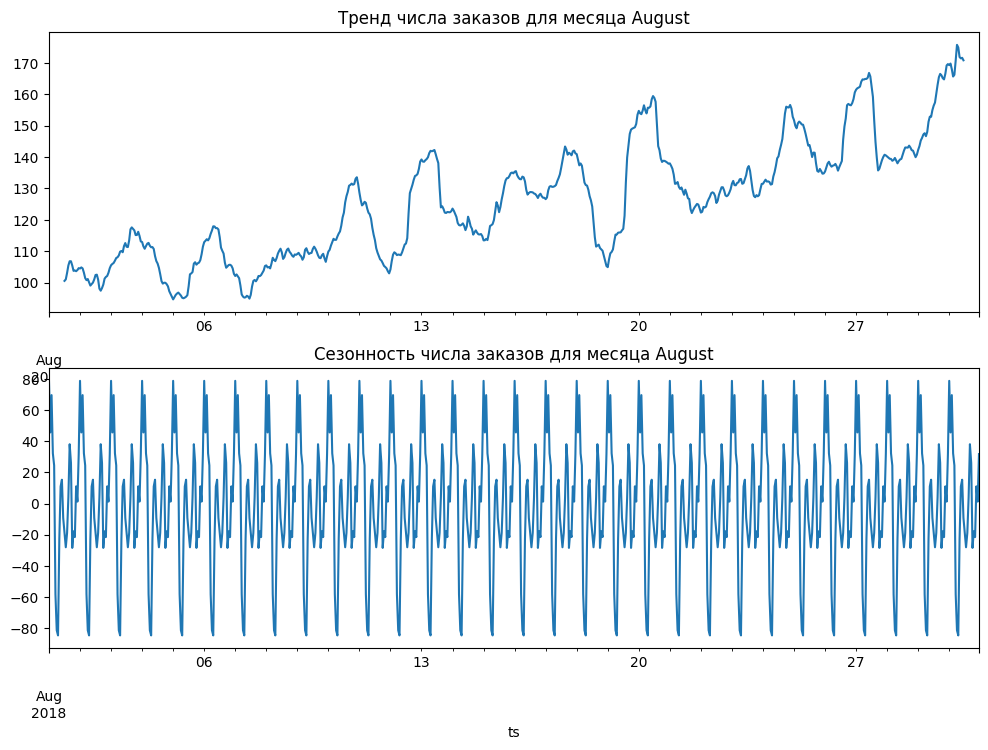

In [50]:
# запускаем цикл по месяцам
for month in data.index.month.unique():
    temp_df = data[f'2018-{month}-01': f'2018-{month}-30' ].resample('1H').sum()
    month_name = calendar.month_name[month]

    plot_trend_seasonality(temp_df, month_name)



Вывод: и тренд, и сезонность по месяцам по логике изменения почти не отличаются.

Однако, в летние месяцы число заказов существенно выше, чем в весенние. Особенно выделяется август

Сделаем тренд и сезонность по двум месяцам: весенний и летний

1) сделаем два среза - один на весенний месяц(апрель), второй на летний месяц (июль)

2) посмотрим на тренд и сезонность по часам разных дней (возьмем 4 рандомных дня)


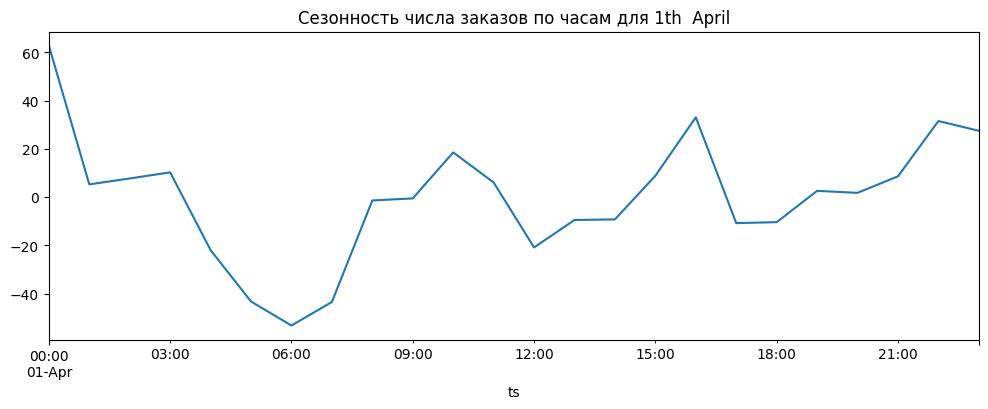

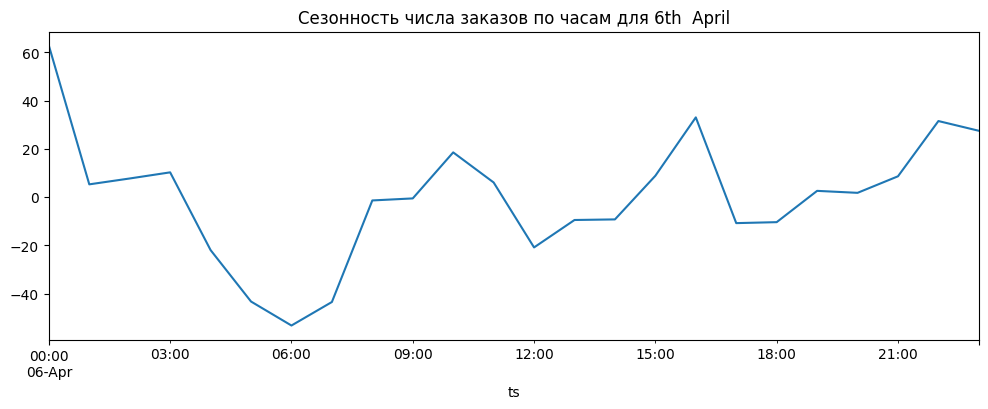

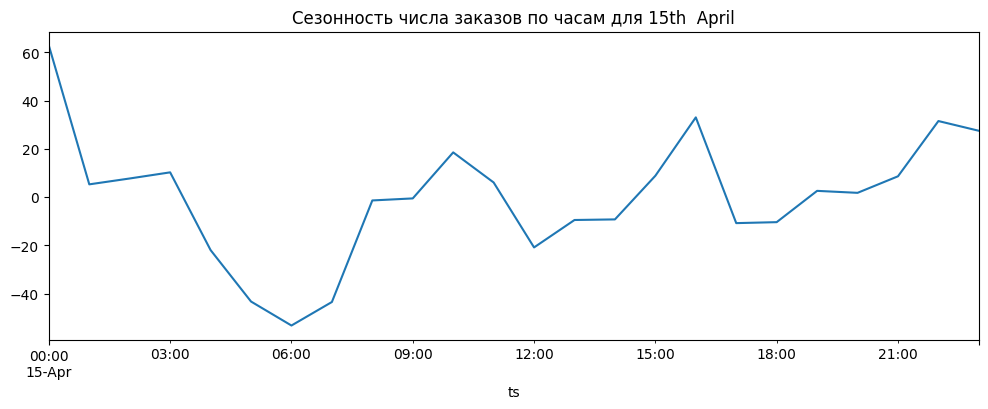

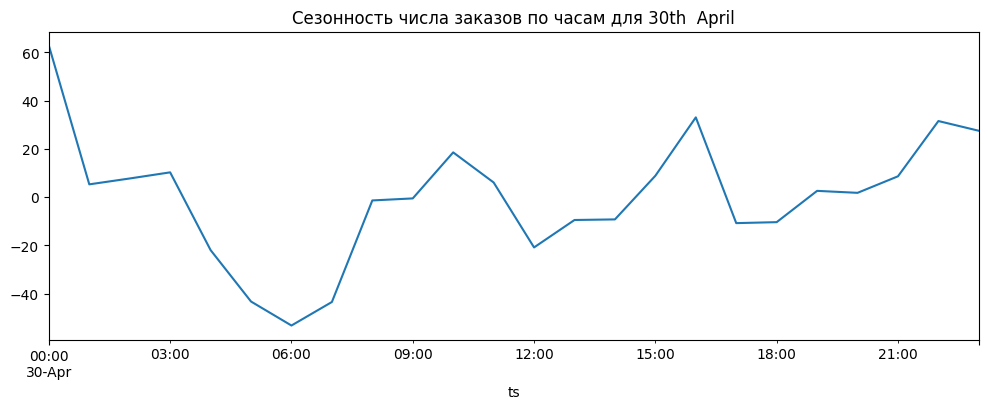

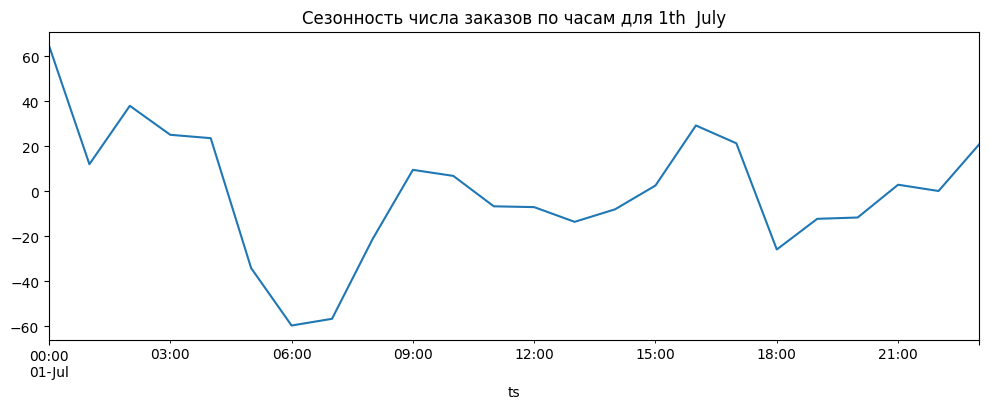

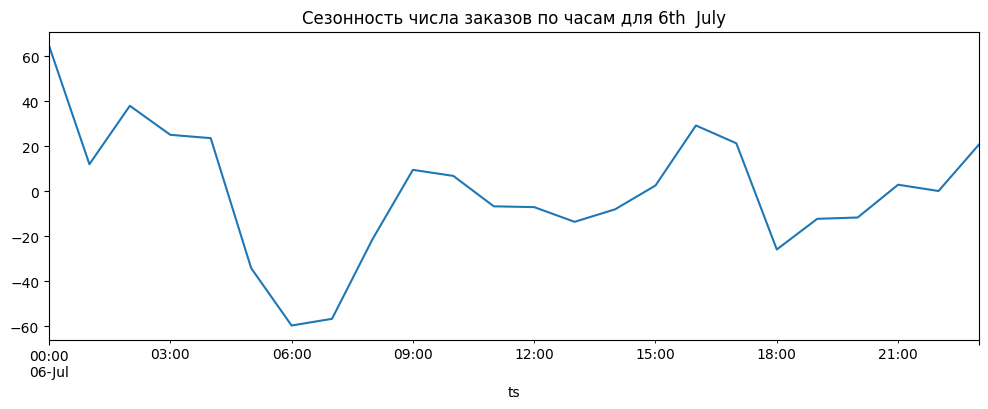

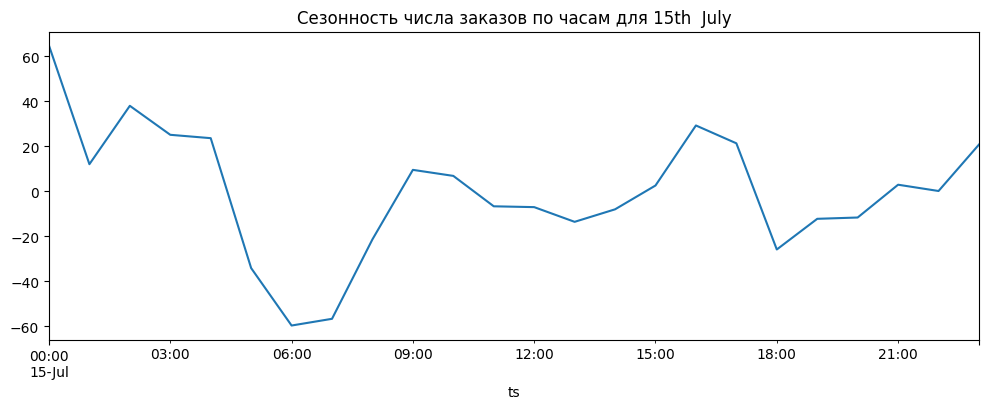

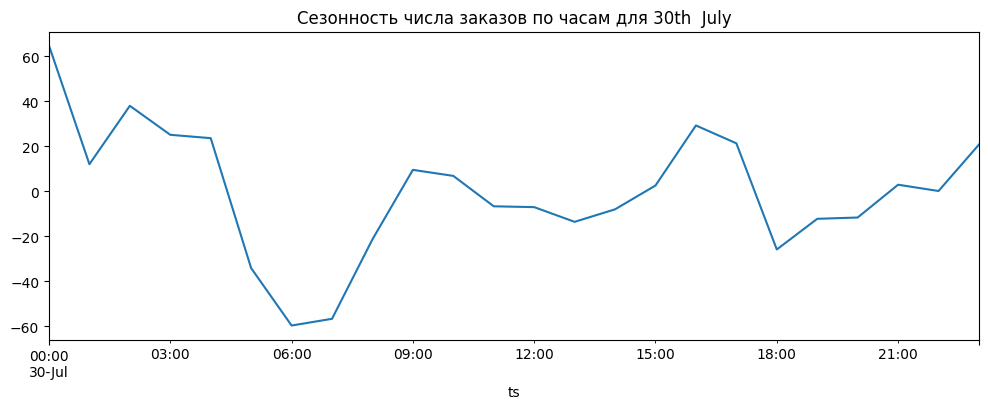

In [66]:

# напишем функцию построения для удобства

def plot_seasonality_per_day(temp_df, month, day_num):

    decomposed = seasonal_decompose(temp_df) 

    plt.figure(figsize=(12, 4))
   
    decomposed.seasonal[f'2018-{month}-{day_num} 00:00:00': f'2018-{month}-{day_num} 23:59:59'].plot(ax=plt.gca()) 
    plt.title(f'Сезонность числа заказов по часам для {day_num}th  {month_name}')


# запускаем цикл по месяцам
for month in [4,7]:
    temp_df = data[f'2018-{month}-01': f'2018-{month}-30'].resample('1H').sum()
    month_name = calendar.month_name[month]

    for day_num in [1,6,15,30]:
        plot_seasonality_per_day(temp_df, month_name, day_num)



Вывод: сезонность заказов каждый час для разных дней в весеннем и летнем месяце практически идентична:
- повышенный спрос между 21:00 и 3:00
- резкий спад между 4 и 7 утра
- невысокий, но стабильный спрос между 9 и 17 часами

### 2.2. Разности временного ряда
Чтобы ряд сделать стационарным, найдём разности его значений.

Разности временного ряда (англ. time series difference) — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.

Для поиска разностей временного ряда применяется метод shift() (англ. «сдвиг»). Все значения он сдвигает вдоль временной оси на один шаг вперёд:

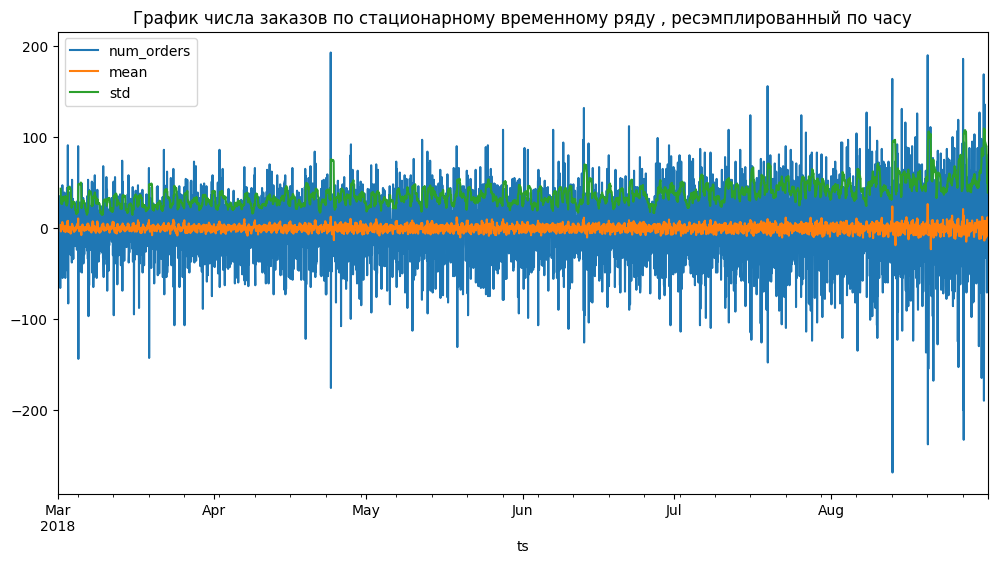

In [51]:
temp_df = data.resample('1H').sum()

temp_df = temp_df - temp_df.shift(fill_value=0)  

temp_df['mean'] = temp_df['num_orders'].rolling(15).mean()
temp_df['std'] = temp_df['num_orders'].rolling(15).std()

temp_df.plot(figsize=(12,6))
plt.title('График числа заказов по стационарному временному ряду , ресэмплированный по часу')

plt.show()

Вывод: разность по временному ряду сделала его более стационарным (средняя линия проходит практически по нулевому значению), а значит такой ряд лушче подойдет для прогнозирования

### 2.3 Общий вывод по анализу:

1) Тренд показывает ежемесячный стабильный прирост от весеннх месяцев к летний, пик наблюдается в августе
2) Логика сезонности заказов не меняется от месяца к месяцу

3) Логика почасовой сезонности также неизменна:
    - повышенный спрос между 21:00 и 3:00
    - резкий спад между 4 и 7 утра
    - невысокий, но стабильный спрос между 9 и 17 часами

4) Разность по временному ряду сделала его более стационарным - подходит для прогнозирования

## 3. Обучение 

### 3.1. Прогнозирование без обучения

#### 3.1.1. Замена прогнозного значения константой - медианой по тренировочной выборке

In [70]:
train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1)    # выделяем на тренировочную выорбку 10%


print("Среднее число заказов в час:", test['num_orders'].mean())

pred_median = np.ones(test.shape) * train['num_orders'].median()   # считаем медиану для тренировочной выборки 
                                                                # и создаем массив размером тестовой выборки, заполненной ТОЛЬКО медианой тренировочной выборки

print("MAE:", mean_absolute_error(test, pred_median))

Среднее число заказов в час: 139.55656108597285
MAE: 70.7918552036199


Ошибка довольно высокая - чуть больше 50%

#### 3.1.2. Замена прогнозного значения предыдущим значением ряда

In [71]:
train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1)    # выделяем на тренировочную выорбку 10%

print("Среднее число заказов в час:", test['num_orders'].mean())

pred_previous = test.shift(fill_value=train.iloc[-1,-1])

print("MAE:", mean_absolute_error(test, pred_previous))

Среднее число заказов в час: 139.55656108597285
MAE: 44.97285067873303


Ошибка значительно уменьшилась - 31%

Вывод: итак, ориентир для обучения - ошибка MAE должна быть не выше 45 заказов

Обязательное условие - метрика RMSE не должна превышать 48 заказов, этим займемся на этапе обучения модели

### 3.2. Прогнозирование с обучением

#### 3.2.1. Создание признаков

создадим функцию для создания признаков:
- календарных значений: месяц, день, день недели, час
- разности (для стационарности ряда)
- скользящего среднего - как признак общего тренда временного ряда

In [73]:

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()   # решение проблемы с попаданием целевого признака 
                                                                                        # в предсказываемое значение:
                                                                                        # просто сдвигаем ряд на единицу!
   


In [74]:
# применим функцию, выведем 5 первых значений
make_features(data_resampled, 2, 2)             # пока зададим число сдвигов и размер скользящего окна = 2
print(data_resampled.head())

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
ts                                                                           
2018-03-01 00:00:00         124      3    1          3     0    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     1  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     2   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     4   66.0   71.0   

                     rolling_mean  
ts                                 
2018-03-01 00:00:00           NaN  
2018-03-01 01:00:00           NaN  
2018-03-01 02:00:00         104.5  
2018-03-01 03:00:00          78.0  
2018-03-01 04:00:00          68.5  


#### 3.2.2 Обучение модели
Обучим линейную регрессию с учётом новых признаков.

Разделим данные на обучающую и тестовую выборки. Отстающие значения и скользящее среднее вычисляются по прошлым данным. Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.

Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет. Пустые значения просто удалим



In [75]:
train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

model = LinearRegression()

model.fit(X_train, y_train)

print("MAE обучающей выборки:", mean_absolute_error(y_train, model.predict(X_train)))
print("MAE тестовой выборки:", mean_absolute_error(y_test, model.predict(X_test)))

MAE обучающей выборки: 23.507970526822195
MAE тестовой выборки: 40.30568826325443


С абсолютной ошибкой все хорошо, а как дела с заданной (RMSE)?

In [76]:


print("RMSE обучающей выборки:", root_mean_squared_error(y_train, model.predict(X_train)))
print("RMSE тестовой выборки:", root_mean_squared_error(y_test, model.predict(X_test)))

RMSE обучающей выборки: 30.672169212335678
RMSE тестовой выборки: 52.722677659224594


Итак, значение на тестовой выборке пока неудовлетворительное (нужно менее 48).

#### 3.2.3 Подбор числа признаков для улучшения метрики RMSE

Попробуем прогнать через цикл подбор числа признаков

In [84]:
rmse_score = 53
num_iter = 0
for lag in range(3,10):
    for rms in range(3,10):
        num_iter +=1
        
        data_resampled = data.resample('1H').sum()

        make_features(data_resampled, lag, rms)

        train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1)
        train = train.dropna()

        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']

        X_test = test.drop('num_orders', axis=1)
        y_test = test['num_orders']

        model = LinearRegression()

        model.fit(X_train, y_train)

        rmse_score = root_mean_squared_error(y_test, model.predict(X_test))

        print(f'Итерация{num_iter}, метрика = {rmse_score}')


print(f'lag = {lag}, rolling_mean_size = {rms}')



print("RMSE обучающей выборки:", root_mean_squared_error(y_train, model.predict(X_train)))
print("RMSE тестовой выборки:", root_mean_squared_error(y_test, model.predict(X_test)))

Итерация1, метрика = 52.4313885381067
Итерация2, метрика = 52.57450685373692
Итерация3, метрика = 52.73155022715022
Итерация4, метрика = 53.046672353533
Итерация5, метрика = 52.95894315730787
Итерация6, метрика = 52.86279977555047
Итерация7, метрика = 53.22879067779113
Итерация8, метрика = 52.574506853736935
Итерация9, метрика = 52.574506853736935
Итерация10, метрика = 52.692761288945725
Итерация11, метрика = 52.970688626886584
Итерация12, метрика = 52.764634869980945
Итерация13, метрика = 52.6467314345853
Итерация14, метрика = 53.05220145848406
Итерация15, метрика = 52.66711049739565
Итерация16, метрика = 52.69276128894574
Итерация17, метрика = 52.69276128894572
Итерация18, метрика = 53.051434353205245
Итерация19, метрика = 52.68349979386234
Итерация20, метрика = 52.55862484562421
Итерация21, метрика = 53.022865256108986
Итерация22, метрика = 53.051434353205245
Итерация23, метрика = 53.05143435320524
Итерация24, метрика = 53.05143435320524
Итерация25, метрика = 53.139983801873804
Итер

Метрика ниже 52 не опускается, будем работать с моделями

#### 3.2.4. Несколько моделей. Пайплайны

Снова поделим данные на тестовую и тренировочную выборки, причем:
- назначим размер сдвига - 24, т.к в сутках 24 часа (так будем избегать попадания в целевую перменную информации о прошедших сутках)
- размер окна для скользящего среднего примем равным 2

In [90]:
data_resampled = data.resample('1H').sum()

make_features(data_resampled, max_lag=24, rolling_mean_size=2)    

train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Указываем тип данных для кодировки, финалим пайплайн для обучения

In [93]:
num_cols = X_train.columns

In [94]:

col_transformer = ColumnTransformer(
    [
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [95]:
final_pl = Pipeline(
    [
        ('prep', col_transformer),
        ('models', DecisionTreeRegressor(random_state=42))
    ]
)

Устанавливаем параметры для обучения четырех моделей:
- градиентный бустинг: CatBoostRegressor, XGBRegressor, LGBMRegressor
- дерево решений (регрессор)

In [96]:
params = [
    {
        'models': [CatBoostRegressor(random_state=42, verbose=10), 
                   LGBMRegressor(random_state=42)],
        'models__learning_rate':  [0.1, 0.25], 
        'models__max_depth': [10, 12],
        'models__n_estimators': [200], 
        'prep__num': ['passthrough']
    },
    {
        'models': [XGBRegressor(random_state=42)],
        'models__learning_rate':  [0.1, 0.12],
        'models__max_depth': [10, 12],
        'models__n_estimators': [200],
        'prep__num': ['passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(3, 5),
        'models__min_samples_split': range(3, 5),
        'models__min_samples_leaf': range(3, 5),
        'prep__num': ['passthrough']
    }
]

Запускаем поиск

In [97]:
search = GridSearchCV(
    final_pl,
    param_grid=params,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error' # задаем отрицательное значение метрики в целях минимизации ошибки
)

In [98]:
search.fit(X_train, y_train)

0:	learn: 32.6126368	total: 337ms	remaining: 1m 7s
0:	learn: 37.5380387	total: 338ms	remaining: 1m 7s
0:	learn: 37.6620868	total: 337ms	remaining: 1m 7s
0:	learn: 37.2531325	total: 342ms	remaining: 1m 8s
0:	learn: 37.5837672	total: 387ms	remaining: 1m 17s
0:	learn: 37.3063410	total: 937ms	remaining: 3m 6s
0:	learn: 37.6299183	total: 1.18s	remaining: 3m 54s
0:	learn: 37.7386231	total: 1.19s	remaining: 3m 56s
10:	learn: 26.5797969	total: 2.83s	remaining: 48.6s
10:	learn: 23.1100300	total: 2.95s	remaining: 50.7s
10:	learn: 26.0630656	total: 3.01s	remaining: 51.8s
10:	learn: 26.2621728	total: 3.06s	remaining: 52.6s
10:	learn: 26.6899814	total: 3.26s	remaining: 56.1s
20:	learn: 22.3594361	total: 5.03s	remaining: 42.9s
20:	learn: 19.6645844	total: 5.11s	remaining: 43.5s
20:	learn: 21.7369316	total: 5.23s	remaining: 44.6s
20:	learn: 22.1662156	total: 5.27s	remaining: 45s
20:	learn: 22.5838568	total: 5.55s	remaining: 47.3s
10:	learn: 26.3175477	total: 6.21s	remaining: 1m 46s
10:	learn: 26.3307

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
       'lag_17', 'lag_18', 'lag_19', 'lag_2...
                                                  random_state=42, ...)],
                          'models__learning_rate': [0.1, 0.12],
                          'models__max_depth': [10, 12],
                          'models__n_estimators': [200],
                          'prep__num': ['passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(3, 5),
                          'models__min_samples_leaf': range(3, 5),
                          'models__min_samples_split': range(3, 5),
                          'prep__num': ['passthrough']}],
             scoring='neg_root_mean_squared_error')

In [100]:
search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
       'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23',
       'lag_24'],
      dtype='object'))])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x13b6a2cb0>)])

Проверим предсказания лучше модели на тестовой выборке по заданной метрике - RMSE

In [103]:
best_model =search.best_estimator_



print("RMSE тестовой выборки:", root_mean_squared_error(y_test, best_model.predict(X_test)))


RMSE тестовой выборки: 45.67776298601626


Результат достигнут, метрика менее 48 заказов

#### 3.2.5. Настройка лучшей модели

Повторим поиск, но с тюнингом - При работе с временными рядами будем использовать не стандартную кросс-валидацию, а TimeSeriesSplit

Причина - при стандартной кросс-валидации в определенный момент тренировочная выборка окажется позже валидационной, а это неприемлемо в работе с временными рядами

In [106]:
tscv = TimeSeriesSplit(n_splits=5)

In [107]:
search_ts = GridSearchCV(
    final_pl,
    cv=tscv,
    param_grid=params,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error' # задаем отрицательное значение метрики в целях минимизации ошибки
)

In [108]:
search_ts.fit(X_train, y_train)

0:	learn: 28.6341622	total: 90.1ms	remaining: 17.9s
0:	learn: 29.1092528	total: 125ms	remaining: 24.9s
0:	learn: 33.1370290	total: 263ms	remaining: 52.4s
0:	learn: 30.6359722	total: 272ms	remaining: 54.1s
0:	learn: 29.1206333	total: 288ms	remaining: 57.3s
0:	learn: 28.6830848	total: 283ms	remaining: 56.4s
0:	learn: 31.8201474	total: 346ms	remaining: 1m 8s
0:	learn: 30.6864193	total: 376ms	remaining: 1m 14s
10:	learn: 21.7768097	total: 1.88s	remaining: 32.3s
10:	learn: 20.0235821	total: 1.9s	remaining: 32.6s
10:	learn: 20.6412462	total: 1.94s	remaining: 33.3s
10:	learn: 23.5658268	total: 2.08s	remaining: 35.8s
10:	learn: 22.7194324	total: 2.33s	remaining: 40.1s
20:	learn: 15.4009757	total: 3.37s	remaining: 28.7s
10:	learn: 20.0003529	total: 3.54s	remaining: 1m
10:	learn: 20.5792836	total: 3.65s	remaining: 1m 2s
20:	learn: 16.6992844	total: 3.65s	remaining: 31.1s
20:	learn: 17.8919804	total: 3.69s	remaining: 31.5s
20:	learn: 19.8932200	total: 3.9s	remaining: 33.2s
20:	learn: 18.9586937	t

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_1...
                                                  random_state=42, ...)],
                          'models__learning_rate': [0.1, 0.12],
                          'models__max_depth': [10, 12],
                          'models__n_estimators': [200],
                          'prep__num': ['passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(3, 5),
                          'models__min_samples_leaf': range(3, 5),
                          'models__min_samples_split': range(3, 5),
                          'prep__num': ['passthrough']}],
             scoring='neg_root_mean_squared_error')

In [109]:
search_ts.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
       'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23',
       'lag_24'],
      dtype='object'))])),
                ('models',
                 LGBMRegressor(max_depth=10, n_estimators=200,
                               random_state=42))])

In [110]:
best_model_ts = search_ts.best_estimator_


print("RMSE тестовой выборки:", root_mean_squared_error(y_test, best_model_ts.predict(X_test)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE тестовой выборки: 40.063730853662754


Обучим итоговую модель, но учтем рекомендацию LGBMRegressor - установим num_leaves модели не менее 2^max_depth: 
- max_depth = 3
- num_leaves = 10 > 2**3

In [128]:
new_model = LGBMRegressor(max_depth=3, n_estimators=200, random_state=42, num_leaves=10, force_col_wise=True, verbosity=-1)

new_model.fit(X_train, y_train)

print("RMSE тестовой выборки:", root_mean_squared_error(y_test, new_model.predict(X_test)))
print("MAE тестовой выборки:", mean_absolute_error(y_test, new_model.predict(X_test)))


RMSE тестовой выборки: 39.67678325972011
MAE тестовой выборки: 29.127091285703166


Вывод: лучшей моделью стала модель градиентного бустинга LGBMRegressor, лучшие значения метрик:
- МАЕ = 29 (меньше, чем при прогнозировании без обучения = 45)
- RMSE (целевая метрика) = 39.7 (~40 заказов) 


#### 3.2.6. Проверка на "глупую" модель

In [130]:
dummy_model = DummyRegressor()

X_train_dummy = col_transformer.fit_transform(X_train, y_train)
X_test_dummy = col_transformer.transform(X_test)

dummy_model.fit(X_train_dummy, y_train)
dummy_model_preds = dummy_model.predict(X_test_dummy)

      
print(f'Метрика RMSE на тестовой выборке для dummy-модели :', root_mean_squared_error(y_test, 
    dummy_model_preds))  

Метрика RMSE на тестовой выборке для dummy-модели : 84.6499381993622


Проверка на адекватность пройдена

### 3.3 Визуализация тестовых и предсказанных значений 

In [133]:
def plot_datas(data_test, data_pred):
    fig, ax = plt.subplots(figsize=(16, 6))       
    ax.plot(
    data_test.index,
    data_test.values,
    linewidth = 2,
    label = 'Тестовые данные',
    color='green'
    )

    ax.plot(
    data_test.index,
    data_pred,
    linewidth = 2,
    label = 'Спрогнозированные данные',
    color='red' 
    )
        
    ax.set_title(f'График сравнения предсказанных и реальных данных' + "\n", fontsize = 14, color = 'Black');       
    plt.ylabel(f'Количество заказов', fontsize=12)
    plt.xlabel(f'Дата', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12, rotation=70);
    ax.legend()

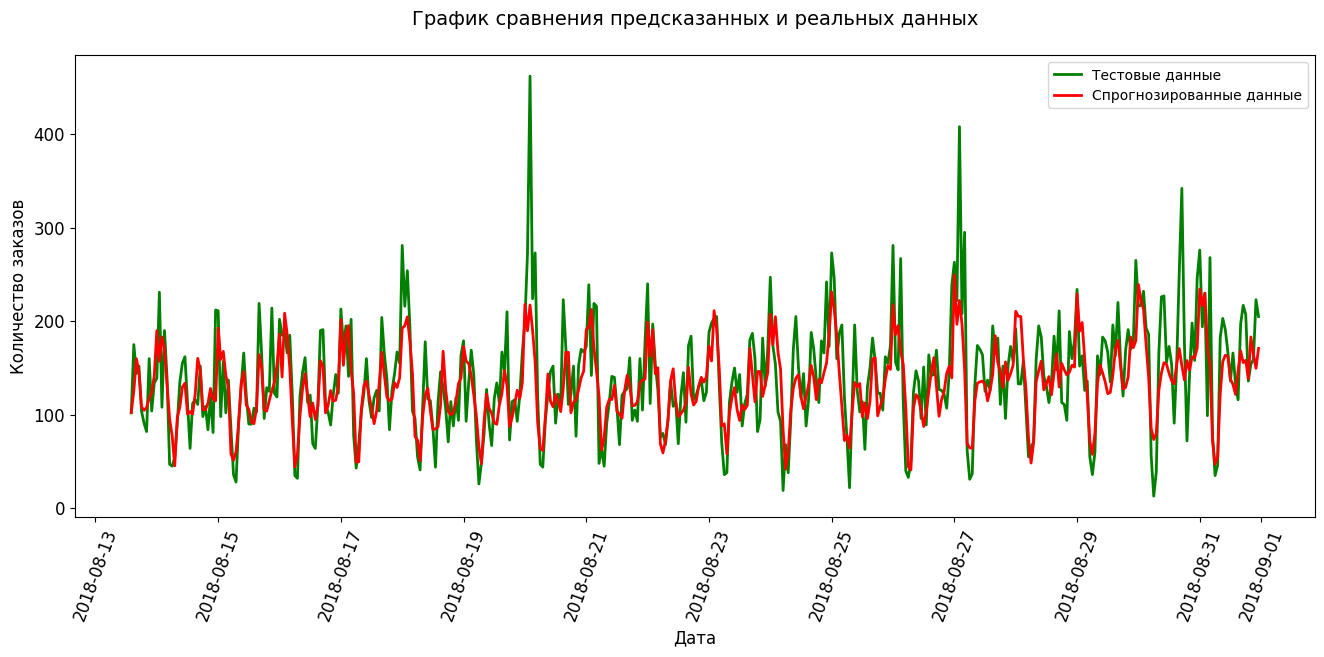

In [134]:
plot_datas(y_test, new_model.predict(X_test))

## 4. Выводы

1) В ходе работы над проектом получены и изучены данные о заказах такси за полгода: с марта по август 2018 года
    - данные подготовлены к работе
    - выполнено ресэмплирование по часу (для предсказания потребности такси на следующий час)

2) Проведен анализ данных:
    - тренд показывает рост потребности от весенних к летним месяцам, пик наблюдается в августе
    - сезонность по месяцам носит монотонный характер
    - сезонность заказов каждый час для разных дней в весеннем и летнем месяце практически идентична: повышенный спрос между 21:00 и 3:00; резкий спад между 4 и 7 утра; невысокий, но стабильный спрос между 9 и 17 часами
    - разность по временному ряду делает его более стационарным и подходящим для прогнозирования (околонулевое значение скользящего среднего)

3) Прогнозирование выполнено в двух вариантах:
    - без обучения модели (лучшее значение метрики MAE - ошибка в 45 заказов или 30%)
    - с обучением модели



4) Обучение было выполнено
    - на линейной регресии - лучшее значение метрики всего 52 заказа
    - подбором из 4 моделей: три модели градиентного бустинга и одна решающих деревьев

<font color='red'>

Итогом подбора лучшей модели стала модель LGBMRegressor, причем ее метрики:
- абсолютная ошибка МАЕ = 30 заказов
- лучшая метрика RMSE =  40 заказов.

Требуемый результат Заказчика достигнут.
</font>
